In [15]:
# Import packages
import numpy as np
import pandas as pd
import pickle
import scipy as sp
from time import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
from textblob import TextBlob
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))

%matplotlib inline 

In [5]:
# Load data
with open('data/scraped_data_all_recipes_without_link.pickle', 'rb') as f:
    data_allrecipes = pickle.load(f)
data_allrecipes = pd.DataFrame(data_allrecipes)
data_allrecipes.drop_duplicates('instruction', inplace=True) # remove duplicate based on instructions
shortest_instruction = 50
data_allrecipes = data_allrecipes[data_allrecipes['instruction'].str.len()>=shortest_instruction] # Filter by instruction length
data_allrecipes.reset_index(drop=True, inplace=True)
data_allrecipes.drop(29554, inplace=True)
data_allrecipes.drop(29551, inplace=True) # id = 101923,102126, drop them because of duplicate (too similar but not the same)
data_allrecipes.reset_index(drop=True, inplace=True)


## Get 1-gram features from instructions

In [6]:
instruction_words, instruction_id = [], []
data_allrecipes['instruction'] = data_allrecipes['instruction'].str.replace(r'\d', '') # remove numbers
# word count feature
t0 = time()
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords_list)
X_train_counts = count_vect.fit_transform(data_allrecipes['instruction']).todense()
print('Word count feature extraction done ({} sec)'.format(time()-t0))
# word frequency (tdidf) feature
t0 = time()
tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords_list)
X_train_tfidf = tfidf_vect.fit_transform(data_allrecipes['instruction']).todense()
print('Tf-idf feature extraction done ({} sec)'.format(time()-t0))

Word count feature extraction done (2.0492374897003174 sec)
Tf-idf feature extraction done (1.9956488609313965 sec)


## Topic model analysis

In [7]:
n_components = 10
n_top_words = 30

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# NMF model using tf-idf features
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(X_train_tfidf)
print("NMF done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = count_vect.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

## LDA model using raw count features
# lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)
# t0 = time()
# lda.fit(X_train_counts)
# print("done in %0.3fs." % (time() - t0))
#
# print("\nTopics in LDA model:")
# tf_feature_names = count_vect.get_feature_names()
# print_top_words(lda, tf_feature_names, n_top_words)

# Assign topic index to each observation
topic = []
for i in range(tsne_result.shape[0]):
    topic.append(np.argmax(nmf.transform(X_train_tfidf[i,:])))
topic = np.array(topic)


NMF done in 230.909s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: degrees mixture oven pan sugar flour butter bowl mix bake beat eggs stir cup minutes together cool inch baking cake brown egg milk combine cream pour set well grease batter
Topic #1: heat cook medium stir add minutes skillet simmer pepper boil onion tender bring large stirring low reduce high garlic sauce saute pot onions saucepan water rice beef drain cover oil
Topic #2: degrees dish cheese oven preheat top bake baking bread sprinkle place preheated minutes casserole spread layer lightly foil pepper slices inch arrange brown mix onion sauce soup evenly remaining slice
Topic #3: cookie sheets dough sheet cookies baking onto drop balls roll inches sugar apart cool ungreased flour together stir wire racks minutes shortening soda well preheat vanilla butter shape place chocolate
Topic #4: grill juice place orange lemon serve lime ice hours small glass combine cover refrigerate desired bowl mixt

## t-SNE embedding

In [10]:
# Preprocess: use PCA to reduce the number of features
t0 = time()
pca = PCA(n_components=100)
pca_result = pca.fit_transform(X_train_tfidf)
print("PCA done in %0.3fs." % (time() - t0))

## t-SNE embedding
t0 = time()
tsne = TSNE()
tsne_result = tsne.fit_transform(pca_result)
print("t_SNE done in %0.3fs." % (time() - t0))

PCA done in 5.763s.
t_SNE done in 1102.652s.


## Visualization

/shared/homes/rxia/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:2141: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


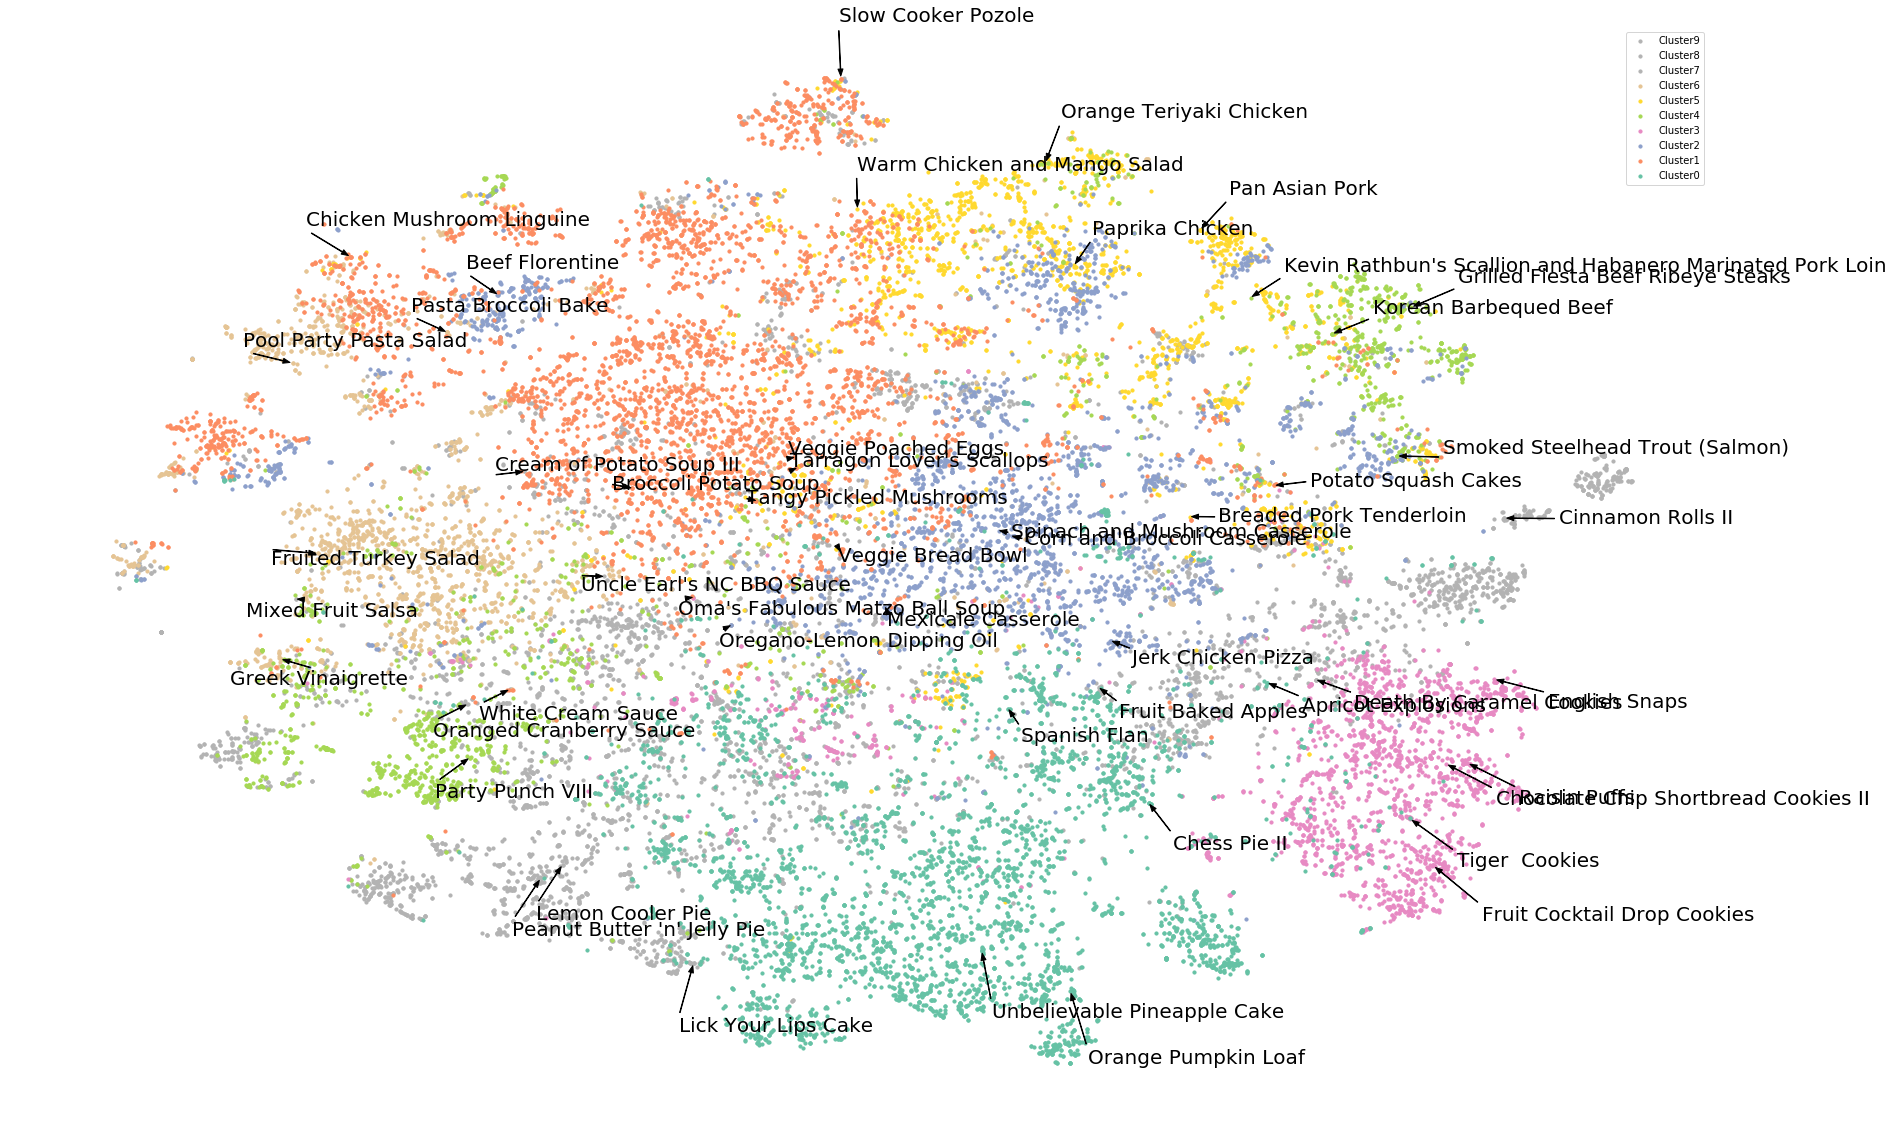

In [26]:
plt.figure(figsize = [30,20])
ax = plt.gca()
small_sample_index = np.random.choice(tsne_result.shape[0],30000)
n_titles_per_cluster = 5
tsne_result_small = tsne_result[small_sample_index,:]
topic_small = topic[small_sample_index]
titles_small = data_allrecipes['title'][small_sample_index]
for i in np.unique(topic_small)[-1::-1]:
    X = tsne_result_small[topic_small==i,0]
    Y = tsne_result_small[topic_small==i,1]
    plt.scatter(X,Y,c=matplotlib.cm.get_cmap('Set2')(i),label='Cluster{}'.format(i),s=10)
    titles = np.array(titles_small[topic_small==i])
    for j in np.random.choice(X.shape[0],n_titles_per_cluster):
        title = titles[j]
        ax.annotate(title,xy=(X[j],Y[j]), textcoords='offset points', fontsize=20, 
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=7),
            horizontalalignment='middle', verticalalignment='top')
plt.legend()
_ = plt.axis('off')


## Preparation for the visualization 2

In [ ]:
## Word co-occurance correlation matrix
X_train_tfidf = np.array(X_train_tfidf)
feature_choice = np.arange(0,X_train_tfidf.shape[1]) # Choose all features
Cov = np.cov(np.transpose(X_train_tfidf[:,feature_choice])) 
Std = np.std(X_train_tfidf[:,feature_choice], axis=0)
Corr = Cov / ((Std[:, None]+0.01) * (Std[None, :]+0.01)) # Soft normalizing the covariance matrix to weaken the influence of rare words
Corr[Corr<0.1] = 0
names = np.array(count_vect.get_feature_names())[feature_choice]
df = pd.DataFrame(data = Corr, columns = names, index = names)
df.to_csv('to_gephi.csv', sep = ',')

# The visualization was then performed in Gephi